In [266]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pd.options.mode.chained_assignment = None

In [267]:
file_location = "C:\\Github\\DIP\\bikes.csv"

# FlickBike

In dit notebook wordt een analyse uitgevoerd op een aantal bedrijfsprocessen en -vragen met het doel om een verbetering door te brengen in de processen. Door middel van statistiek en een aantal AI technieken bieden wij inzichten in de FlickBike dataset. Zo hopen we een goed plan/advies op te leveren waarin wij een aantal vragen die door FlickBike opgesteld zijn beantwoorden. In dit notebook zullen de volgende vragen naar voren komen en uitgewerkt worden in een logische volgorde.

1. Hoe voorspel je de groei van FlickBike? Hoe voorspel je het aantal verhuurde fietsen in bepaalde tijdspannes?
2. Hoe kan voorspeld worden op welke plekken fietstekorten kunnen ontstaan?
3. Hoe kan het minimaal benodigd aantal fietsen voorspeld of berekend worden (per locatie)?

Door middel van datainzichten, grafieken en uitleg hopen wij een goed leesbaar verslag op te leveren. Voor het bedenken van verschillende modellen moet ook correlatie onderzoek uitgevoerd worden. Welke factoren hebben wel of geen invloed op het model? Verschillende factoren, zoals het weer, zijn meegenomen in het onderzoek naar passende modellen voor het bovenstaande vragen.

#### Data inlezen en voorbereiden

In [268]:
df_flickbike = pd.read_csv(file_location)
df_flickbike["date"] = pd.to_datetime(df_flickbike["date"],format="%Y-%m-%d %H:%M:%S")
day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df_flickbike['weekday'] = pd.to_datetime(df_flickbike['start_time']).dt.dayofweek.map(day_of_week)
df_flickbike.head()

,Unnamed: 0,tripid,userid,bikeid,account,bikenumber,start_time,end_time,start_lat,start_lng,end_lat,end_lng,date,weekday
0,1,33838,13452,382,AR,6631000433,2019-01-01 06:46:03,2019-01-01 06:46:03,52.296065,4.787667,52.296200,4.787679,2019-01-01 06:46:00,Tuesday
1,2,33839,13452,812,AR,6631000146,2019-01-01 06:47:39,2019-01-01 06:47:39,52.295938,4.788336,52.295940,4.788557,2019-01-01 06:47:35,Tuesday
2,3,33851,13182,238,AR,6631000443,2019-01-01 14:15:36,2019-01-01 14:15:36,52.307337,4.807633,52.307336,4.807630,2019-01-01 14:15:32,Tuesday
3,4,33852,13182,238,AR,6631000443,2019-01-01 14:33:50,2019-01-01 14:33:50,52.308478,4.809970,52.308537,4.810099,2019-01-01 14:33:46,Tuesday
4,5,33867,12674,787,AG,6631000283,2019-01-01 20:11:05,2019-01-01 20:11:05,52.506522,4.727323,52.506809,4.732135,2019-01-01 20:11:01,Tuesday


## Hoe voorspel je de groei van FlickBike ?
#### In het bijzonder: hoe voorspel je het aantal verhuurde fietsen op de dagen tussen 10 december 2019 en 31 januari 2020?

De groei van FlickBike is van veel factoren afhankelijk, zowel externe als interne factoren. Veel factoren zullen en/of kunnen niet meegenomen worden in het model omdat deze onberekenbaar, onbereikbaar of niet noemenswaardig zijn. Alle andere factoren die wel beschikbaar zijn moeten op correlatie onderzocht worden. Als bepaalde eigenschappen veel correlatie tonen met de target eigenschap, kunnen deze belangrijk zijn voor het model. 


Naast het correlatie onderzoek hebben we al wat ideeën opgedaan welke factoren we kunnen meenemen in ons model:
    - Dag van de week
    - seizoenen (vakantie seizoen moeten worden herkend door het model)
    - Neerslag/temperatuur/zonnestraling
    - Feestdagen (boolean)
    - Dagdeel (bijvoorbeeld of er vroeg in de ochtend een fiets is gehuurd)
    - Spitsuren per dag en per dagsdeel (in spitsuren pakken werknemers waarschijnlijk eerder de fiets dan de auto)
        - De klassieke spitsuren meegeven als variabelen, of ...
        - Clusters maken per dagdeel of per uur, hiermee schatten hoe druk het is, en dan drukte meegeven als variabele.
    - drukte op straat of op het werk, per dag en per dagsdeel
        - zelfde werkwijze als spitsuren
        - (Drukte op straat zal geen invloed hebben op het gedrag van werknemers. Echter is er wel een verwachte correlatie: als het druk is in de stad is de kans ook groter dat werknemers de fiets pakken. Dit komt door variabelen die wij niet hard kunnen maken, maar die zeker aanwezig zijn. (Denk bijvoorbeeld aan corona virus, weinig mensen gaan de deur uit en weinig mensen pakken de fiets). )

Voor een aantal factoren moet er meer data opgezocht worden en misschien zelfs onderzoek worden gedaan (bijvoorbeeld naar de correlatie tussen drukte/spits rondom schiphol). Een aantal bronnen zijn hiervoor opgezocht met API's die zowel historische als live data bevatten. 

drukte op de weg - https://www.ndw.nu/pagina/nl/103/datalevering/120/open_data/<br>
drukte mensen op straat - https://www.cbs.nl/nl-nl/onze-diensten/innovatie/project/bewegingen-meten-met-anonieme-telefoondata (hier wordt data verzameld van telefoons die aan staan om drukte metingen te maken)


Dit probleem kan lastig opgelost worden met classificatie. Er zal dan hoogstwaarschijnlijk overfitting plaatsvinden ivm het hoge aantal target features. Linear of Non-linear Regression gaat ervan uit dat er een continue directe correlatie aanwezig is tussen input en output. Echter is dit niet het geval met categoriale waarden die zeker meegenomen worden. 

Een van de modellen die gebruikt kan worden voor dit probleem is een decision tree regressor. Dit heeft te maken met voordelen als visualisatie en flexibiliteit, waarbij het laatste vooral belangrijk is om te werken met zowel kwantitatieve waarden (temperatuur) en categoriale waarden (dagen/seizoenen). Bovendien kan decision tree regressor gevalideerd worden met RMSE, dat nodig is het met andere modellen te vergelijken.

Ook wordt er een kwantitatieve waarde als uitkomst verwacht. Met classificatie, zoals een normale desicion tree, wordt er een categoriale uitkomst gegenereerd, terwijl er bij DTR een continue waarde wordt berekend. Dit maakt de uitkomst accurater en gepaster voor de vraagstelling van FlickBike.

### Hoe kunnen bepaalde factoren invloed hebben of krijgen op het model  ? Welke factoren hebben  daadwerkelijk invloed/correlatie?

#### Het weer

Voor het gebruiken van weer moeten eerst een aantal weer factoren gekozen worden. Intuitief zouden bijvoorbeeld de neerslag een invloed kunnen hebben op de verhuur van fietsen ivm het feit dat mensen niet van houden om nat te regenen. Maar dit blijft een aanname. Er zal eerst een correlatie moeten worden gezocht tussen weerfactoren en verandering in fiets verhuur / gebruik. Gebruik makend van de KNMI weer api hebben we een aantal historische weer datapunten opgevraagd en opgeslagen. Voor nu doen we onderzoek naar invloed van neerslag, wind en temperatuur.

In [269]:
# Inlezen en voorbereiden weer dataset
df_weer = pd.read_csv("weer.csv")
df_weer["YYYYMMDD"] = pd.to_datetime(df_weer["YYYYMMDD"],format="%Y%m%d")
df_weer.drop(['STN', 'SQ'], axis=1, inplace=True)
df_weer.rename(columns={'YYYYMMDD':'date','FG':'windspeed','TG':'temperature','RH':'rain'},inplace=True)
df_weer.head()

,date,windspeed,temperature,rain
0,2019-01-01,76,77,5
1,2019-01-02,48,56,-1
2,2019-01-03,23,31,-1
3,2019-01-04,45,54,-1
4,2019-01-05,65,72,1


In [270]:
# Verhuurcijfers samenvoegen met weerdata
df_bikes_per_day = df_flickbike[["tripid"]].groupby([df_flickbike["date"].dt.date]).count()
df_bikes_per_day["day"] = pd.to_datetime(df_bikes_per_day.index,format="%Y-%m-%d %H:%M:%S")
df_weer_verhuur = df_weer.merge(df_bikes_per_day, how='left', left_on='date', right_on="day")
df_weer_verhuur.rename(columns={'tripid':'bikecount'},inplace=True)
df_weer_verhuur.head()

,date,windspeed,temperature,rain,bikecount,day
0,2019-01-01,76,77,5,8.0,2019-01-01
1,2019-01-02,48,56,-1,61.0,2019-01-02
2,2019-01-03,23,31,-1,90.0,2019-01-03
3,2019-01-04,45,54,-1,64.0,2019-01-04
4,2019-01-05,65,72,1,17.0,2019-01-05


In [271]:
# Correlatiematrix
df_weer_verhuur.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,windspeed,temperature,rain,bikecount
windspeed,1.00,-0.06,0.29,-0.21
temperature,-0.06,1.00,0.02,0.18
rain,0.29,0.02,1.00,-0.00
bikecount,-0.21,0.18,-0.00,1.00


Hieruit blijkt dat op het eerste gezicht weer gegevens weinig invloed hebben op het aantal verhuurde fietsen. De grootste correlatie is te zien bij windkracht met een negatieve correlatie van 0.2. Zelfs daar is dus praktisch geen correlatie te vinden. Misschien valt er een betere correlatie te behalen door meerdere variabelen te combineren en een LR model op te stellen, maar veel verbetering wordt hier niet verwacht. 

Een mogelijke reden voor de slechte correlatie kan te maken hebben met waar deze fietsen voor bedoeld zijn, namelijk als vervoer van en naar het werk. Zoals al gezegd is heeft dit niets te maken met woon-werk verkeer en wordt de fiets regelmatig gepakt om bijvoorbeeld wat eten te halen, maar toch worden werknemers meer gedwongen de fiets te pakken dan wanneer iemand in zijn vrije tijd de fiets pakt.

Weer gegevens gaan we dus niet meenemen in de decision tree regressor. Mogelijk is er toch een verband te vinden door de data anders te transformeren of combineren, dus dit wordt de volgende stap. We gaan kijken of we de data zo kunnen selecteren dat er toch correlaties ontstaan. Bijvoorbeeld door te kijken naar specifieke locaties, of speciale omstandigheden.

#### Neerslag:

In [272]:
rain = df_weer_verhuur[['rain', 'bikecount']]

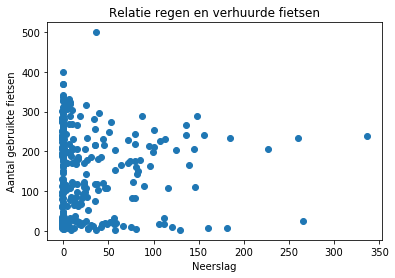

In [273]:
rain.sort_values("rain",inplace=True)
plt.scatter(rain["rain"],rain["bikecount"])
plt.title("Relatie regen en verhuurde fietsen")
plt.xlabel("Neerslag")
plt.ylabel("Aantal gebruikte fietsen")
plt.show()

In [274]:
rain.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,rain,bikecount
rain,1.00,-0.00
bikecount,-0.00,1.00


In [275]:
rain[rain['rain'] > 60].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,rain,bikecount
rain,1.00,0.10
bikecount,0.10,1.00


In [276]:
rain[rain['rain'] > 250].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,rain,bikecount
rain,1.00,0.46
bikecount,0.46,1.00


Hierboven zien we eerst dat er praktisch geen correlatie is tussen neerslag en aantal verhuurde fietsen. Als we de rijen met minder weinig neerslag verwijderen, hebben we opeens steeds meer correlatie.

#### Temperatuur:

In [277]:
temp = df_weer_verhuur[['temperature', 'bikecount']]

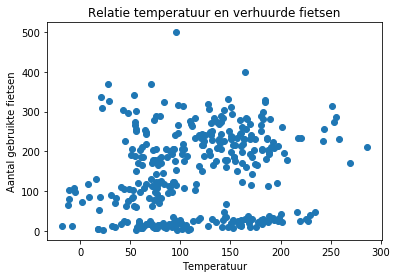

In [278]:
temp.sort_values("temperature",inplace=True)
plt.scatter(temp["temperature"],temp["bikecount"])
plt.title("Relatie temperatuur en verhuurde fietsen")
plt.xlabel("Temperatuur")
plt.ylabel("Aantal gebruikte fietsen")
plt.show()

In [279]:
temp.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,temperature,bikecount
temperature,1.00,0.18
bikecount,0.18,1.00


In [280]:
temp[temp['temperature'] < 50].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,temperature,bikecount
temperature,1.00,0.19
bikecount,0.19,1.00


In [281]:
temp[temp['temperature'] < 10].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,temperature,bikecount
temperature,1.00,0.52
bikecount,0.52,1.00


Wat voor neerslag geldt, geldt ook voor temperatuur. Als de weersomstandigheden koud en nat zijn, worden er dus minder fietsen gehuurd.

#### Windsnelheid:

In [282]:
wind = df_weer_verhuur[['windspeed', 'bikecount']]

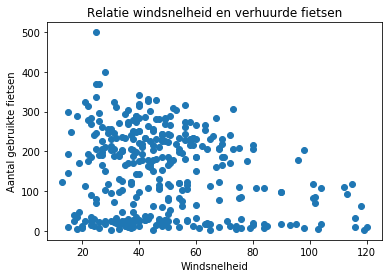

In [283]:
wind.sort_values("windspeed",inplace=True)
plt.scatter(wind["windspeed"],wind["bikecount"])
plt.title("Relatie windsnelheid en verhuurde fietsen")
plt.xlabel("Windsnelheid")
plt.ylabel("Aantal gebruikte fietsen")
plt.show()

In [284]:
wind.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,windspeed,bikecount
windspeed,1.00,-0.21
bikecount,-0.21,1.00


In [285]:
wind[wind['windspeed'] < 50].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,windspeed,bikecount
windspeed,1.00,0.00
bikecount,0.00,1.00


In [286]:
wind[wind['windspeed'] > 90].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,windspeed,bikecount
windspeed,1.00,-0.24
bikecount,-0.24,1.00


In [287]:
wind[wind['windspeed'] > 50].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,windspeed,bikecount
windspeed,1.00,-0.43
bikecount,-0.43,1.00


In [288]:
wind[wind['windspeed'] > 80].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,windspeed,bikecount
windspeed,1.00,-0.08
bikecount,-0.08,1.00


Bij windsnelheid lijkt de correlatie meer op toeval berust dan op een werkelijk verband.

#### Dag van de week

De dag van de week kan ook zeer sterke correlatie hebben met het aantal gebruikte huurfietsen. Je zou zeggen dat doordeweeks meer fietsen gebruikt worden omdat veel mensen alleen doordeweeks werken. Door de dag van de week als integer (1-7) of als string (ma-su) kan een nieuwe kolom met data aan het verhuurbestand toegevoegd worden.

Zoals te zien is in de onderstaande grafiek wordt er inderdaad meer gebruik gemaakt van de huurfietsen. 

<BarContainer object of 7 artists>

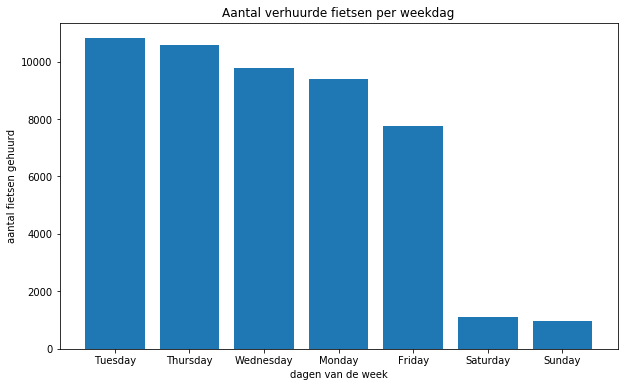

In [289]:
value_counts = df_flickbike['weekday'].value_counts()
plt.figure(figsize=(10,6))
plt.ylabel('aantal fietsen gehuurd')
plt.xlabel('dagen van de week')
plt.title('Aantal verhuurde fietsen per weekdag')
plt.bar(value_counts.keys(), value_counts.values)

Uit bovenstaande grafiek kunnen we concluderen dat er vooral doordeweeks gebruik wordt gemaakt van de huurfietsen. Hierdoor kunnen we aannemen dat de fietsen vooral door doordeweeks werkende of scholende mensen wordt gebruikt.

#### Seizoenen

<BarContainer object of 4 artists>

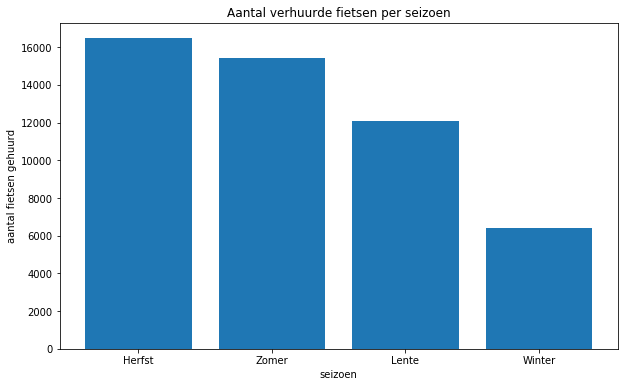

In [305]:
seasons = {1:'Winter', 2:'Lente', 3:'Zomer', 4:'Herfst'}
df_flickbike['season'] = df_flickbike['date'].apply(lambda x: (x.month%12 + 3) // 3).map(seasons)
df_flickbike['season'] = df_flickbike['season']
value_counts = df_flickbike['season'].value_counts()
plt.figure(figsize=(10,6))
plt.ylabel('aantal fietsen gehuurd')
plt.xlabel('seizoen')
plt.title('Aantal verhuurde fietsen per seizoen')
plt.bar(value_counts.keys(), value_counts.values)

Zoals in de bovenstaande grafiek is te zien, worden er de minste fietsen in de winter gebruikt.

#### Bijzondere dagen

Bijzondere dagen kunnen als boolean waarde opgeslagen worden in de dataset. Om de data expansie zo gering mogelijk te houden kunnen bepaalde groepen van bijzondere dagen als gecombineerde waarde bij de dataset gevoegd worden. Dit voorkomt het plaatsen van boolean waardes voor elke bijzondere dag. De groepering kan door bijvoorbeeld een cluster algoritme gemaakt worden waarbij de groepen worden gemaakt op basis van overkeenkomsten in relatie tot de target feature(s)

#### Eventuele andere factoren

Eventuele factoren om mee te nemen zijn:
- concurrenten die de markt opeisen
- financiele of medische crisissen
- bedrijfs/personeels veranderingen/problemen
- Seizoenen

## Hoe kan voorspeld worden op welke plekken fietstekorten kunnen ontstaan

Het is lastig om te voorspellen wanneer er tekorten ontstaan. Je weet immers nooit of iemand ergens een fiets misloopt. Een soort van feedback systeem zou misschien inzicht geven in waar mensen vaak geen fiets kunnen vinden. Ook kan je niet zien hoelang iemand naar een fiets heeft gezocht of hoelang deze persoon ervoor heeft moeten lopen.

Wel kan gekeken worden naar plekken waar veel fietsen worden gebruikt. Met andere woorden, in welk gebied wordt het meest een fiets gepakt en waar wordt het meest gefietst, hotspots. Door de kijken naar het fietsgebruik op bepaalde routes en in bepaalde omgevingen kan een schatting gemaakt waar fietsen hotspots liggen.

Om deze hotspots te vinden is het nodig om met coordinaten te werken. Als eerst kan gekeken worden naar de hoeveelheid fietsen die weer terug komt op de plek van vertrek. Dit kunnen mogelijke hotspots zijn. Daarnaast kan gekeken worden naar het aantal fietsen per plek. Om te werken met coordinaten moet een afstandsfunctie of grids worden gebruikt. 

Om te hotspots te vinden kunnen verschillende methodes worden gebruikt. De data kan bijvoorbeeld op coordinates geclustered worden met een algoritme zoals KMeans (waarbij het soms lastig te bepalen is of het resultaat goed is). Ook kunnen grids van coordinates vastgesteld worden om zo gebieden te creeren waarin het aantal fietsen geteld kan worden (waarbij het 'edge' probleem optreedt waardoor informatie uit belangrijke combinaties van grids verloren gaan).

Als de hotspots bekend zijn, kan gekeken worden hoeveel fietsen er gepakt zijn in een bepaald tijdspanne in de omgeving van deze hotspots. Als er veel fietsen zijn gepakt in een bepaalde omgeving kan dit een mogelijk komend tekort tot gevolg hebben.
Als er een documentatie wordt bijgehouden van het aantal beschikbare fietsen op bepaalde hotspots, kan een bij en af registratie van fietsen in een bepaald gebied worden bijgehouden.

Als laatst kan ook nog gekeken worden naar plekken waar weinig fietsen gebruikt worden maar waarbij wel zeer consistent alle of bijna alle fietsen worden gebruikt over een bepaalde periode. Mogelijk kan het toevoegen van een paar fietsen de missers opvullen.

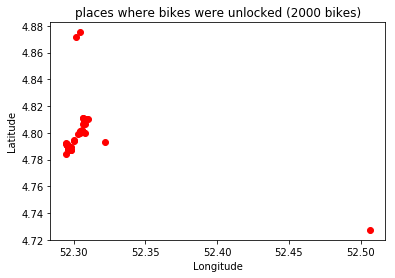

In [290]:
plt.title("places where bikes were unlocked (50 bikes)")
plt.title("places where bikes were unlocked (2000 bikes)")
plt.xlabel("Longitude"),plt.ylabel("Latitude")
plt.plot(df_flickbike["start_lat"].head(50),df_flickbike["start_lng"].head(50),"ro")
plt.show()

Bij kleine aantallen zijn er groepen te herkennen, zo kun je het punt rechtsonder negeren en zal in ieder geval gekeken moeten worden naar de cluster rond 52.3 lat en 4.8 long. Echter zijn de resultaten minder goed categoriseerbaar wanneer je grote aantallen meeneemt:

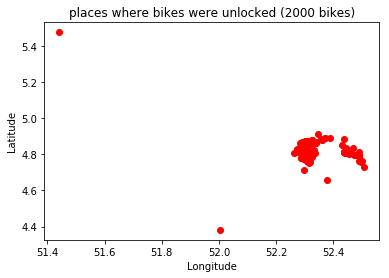

In [291]:
plt.title("places where bikes were unlocked (2000 bikes)")
plt.xlabel("Longitude"),plt.ylabel("Latitude")
plt.plot(df_flickbike["start_lat"].head(2000),df_flickbike["start_lng"].head(2000),"ro")
plt.show()

We zouden hier 2 clusters van kunnen maken, maar de clusters zijn zodanig groot waardoor we geen specifieke risicogebieden kunnen aanduiden. Het valt wel op dat het verschil tussen de eerste 50 fietsen een ander en nauwkeuriger onderscheid lijkt te maken dan die van 2000 fietsen. 

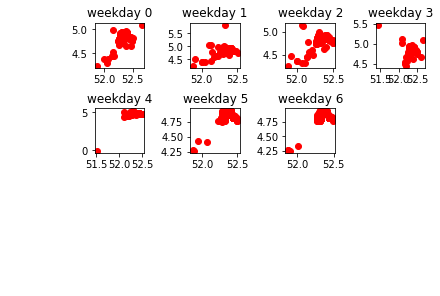

In [292]:
fig2 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=5, nrows=4, figure=fig2)

for i in range(1,8):
    if i<=4:
        x,y = [0,i]
    else:
        x,y = [1,i-4]
    sp = fig2.add_subplot(spec2[x,y])
    df_bikes_weekday = df_flickbike[df_flickbike["date"].dt.weekday==i-1]
    sp.plot(df_bikes_weekday["start_lat"],df_bikes_weekday["start_lng"],"ro")
    plt.title("weekday "+str(i-1))

Hier zien we dat clusters afhankelijk zijn van de soort dag. Zo gaan werknemers op woensdag misschien naar een kraampje dat alleen woensdag open is. Door clusters te onderscheiden per dag kunnen we gebieden iets preciezer bepalen en kunnen we per dag aangeven hoe goed deze clusters zijn.

## Hoe bereken je het minimaal aantal fietsen dat nodig is ?

Om erachter te komen wat het minimaal aantal fietsen is dat nodig is, is het handig om te weten wanneer fietsen wel en niet gebruikt worden. Wij hebben begrepen dat alleen de gebruikte fietsen in de dataset staan, dat wil zeggen, fietsen waarbij het slot open en weer dicht gedaan is. Daarmee is het lastig om te bepalen of er nou een fietstekort is of een teveel aan fietsen. Als kan berekend worden wat de tijd is dat fietsen stil liggen en niet gebruikt worden, kan ook gekeken worden hoeveel fietsen uiteindelijk nodig zijn. Daarom hebben we nog wat meer informatie over de dataset nodig.

Daarnaast kan er ook naar hotspots gekeken worden. Als er een gemiddeld aantal gebruikte fietsen per dag kan worden vastgesteld op een bepaalde plek, kan gekeken worden hoeveel fietsen er werkelijk nodig zijn. Er kan bijvoorbeeld voor een aantal hotspots een minimaal aantal beschikbare fietsen per seizoen of periode vastgesteld worden.

## Hoe wordt alles gevisualiseerd?

<b>Model</b> <br>
Desicion tree regressor kan makkelijk worden gevisualiseerd met scykit learn. Hierbij worden de beslissingen duidelijk getoond. Voor het valideren laten we het verschil zien tussen voorspelde waardes en werkelijke waardes.

<b>Data analyses</b>  <br>
Door de huur van fietsen te visualiseren door de tijd heen kan er patronen herkend worden. Zo verwachten we een periodieke beweging dat veroorzaakt wordt door seizoenen. 
Verder gaan we in een plot clusters van longitude en latitude visualiseren om hiermee op blote oog plekken te herkennen waar veel gefietst wordt. Als er duidelijk clusters voorkomen kan er een classificatie model getraind worden waarmee drukke plekken herkend kunnen worden. Dan weten we ook waar er eventueel een tekort aan fietsen is.

<b>Deelvragen </b>  <br>
Invloeden van het weer zijn al gedeeltelijk gevisualiseerd. Er zijn plots gemaakt waarin de relatie tussen verhuur en weervariabele te herkennen is. Ook is er een correlatiematrix gemaakt.
Tekorten voorkomen wordt op dezelfde manier in een plot getoond waar de pieken zitten, en in dezelfde plot laten we zien hoeveel fietsen beschikbaar zijn. 
